In [23]:
import regex as re
import numpy as np
import plotly.graph_objects as go
from collections import defaultdict

import spacy
nlp = spacy.load("en_core_web_sm")


In [24]:
text = open("/content/NLP.txt").read()
print(text[0:150], "...")

Анализ саундтреков из аккаунтов пользователей позволяет сделать выводы об их музыкальных предпочтениях. А используя наработанные коррелянты можно суди ...


In [25]:
def tokenize_paragrah(paragraph, lemmaOn=False):
    """Build list of sentences and list of tokens for each sentence.
        Punctuation is removed
        If lemmatization is applied, all the tokens are lemmatized first
    """
    doc = nlp(paragraph)
    tokenized_text = []
    for sent in doc.sents:
        if lemmaOn:
            tokenized_text.append([token.lemma_ for token in sent if not token.is_punct])
        else:
            tokenized_text.append([token.text.lower() for token in sent if not token.is_punct])
    return tokenized_text


# def build_bag_of_words(tokenized_paragraph):
#     """Builds two dictionaries that map token into index and vice versa
#     """
#     bow = set()
#     for sent in tokenized_paragraph:
#         for token in sent:
#             bow.add(token)

#     token2id = {}
#     id2token = {}
#     for i, t in enumerate(bow):
#         id2token[i+1] = t
#         token2id[t] = i+1

#     token2id["unk"] = 0
#     id2token[0] = "unk"
#     return id2token, token2id

def build_vocab(tokenized_paragraph):
    word_freq = defaultdict(int)
    for sent in tokenized_paragraph:
        for token in sent:
            word_freq[token] += 1
    word2idx = {word: idx for idx, word in enumerate(word_freq)}
    idx2word = {idx: word for word, idx in word2idx.items()}
    counts = np.array([word_freq[idx2word[i]] for i in range(len(word2idx))], dtype=np.float32)
    freq_table = counts ** 0.75
    freq_table /= freq_table.sum()
    return idx2word, word2idx, freq_table

def one_hot_encode(idx, vocab_size):
    """Converts token id into one-hot vector
    """
    res = [0] * vocab_size
    res[idx] = 1
    return res

def generate_tokens_pairs(sentence, window=2):
    """Generates list of pairs: (central token, token in window-neiborhood of central token)
    """
    tokens_pairs = []
    n_tokens = len(sentence)

    for i, c_token in enumerate(sentence):
        for idx in range(max(0, i - window), i):
            tokens_pairs.append((c_token, sentence[idx]))
        for idx in range(i+1, min(n_tokens, i + window + 1)):
            tokens_pairs.append((c_token, sentence[idx]))
    return tokens_pairs

def get_negative_samples(vocab_size, neg_sample_size, freq_table):
    return np.random.choice(np.arange(vocab_size), size=neg_sample_size, p=freq_table)

def build_training_set(tokens_pairs, token2id, freq_table, neg_sample_size=5):
    X = []
    y = []
    neg_y = []
    for x_token, y_token in tokens_pairs:
        X.append(one_hot_encode(token2id[x_token], len(token2id)))
        y.append(one_hot_encode(token2id[y_token], len(token2id)))
        neg_ids = get_negative_samples(len(token2id), neg_sample_size, freq_table)
        # for i in neg_ids:
        #     print(i, tokens_pairs[i][1])
        #print(neg_ids)
        neg_y.append([one_hot_encode(token2id[tokens_pairs[i][1]], len(token2id)) for i in neg_ids])
    return np.array(X), np.array(y), np.array(neg_y)

In [26]:
tokenized_text = tokenize_paragrah(text)
#id2token, token2id = build_bag_of_words(tokenized_text)
id2token, token2id, freq_table = build_vocab(tokenized_text)
print(token2id)

vocab_size = len(id2token)
print(vocab_size)

print(tokenized_text[0])
tokens_pairs = generate_tokens_pairs(tokenized_text[0])
token_pairs = []
for sentence in tokenized_text:
    tokens_pairs.extend(generate_tokens_pairs(sentence))
train_X, train_y, train_neg_y = build_training_set(tokens_pairs, token2id, freq_table)

print(train_X.shape)

{'анализ': 0, 'саундтреков': 1, 'из': 2, 'аккаунтов': 3, 'пользователей': 4, 'позволяет': 5, 'сделать': 6, 'выводы': 7, 'об': 8, 'их': 9, 'музыкальных': 10, 'предпочтениях': 11, 'а': 12, 'используя': 13, 'наработанные': 14, 'коррелянты': 15, 'можно': 16, 'судить': 17, 'о': 18, 'характере': 19, 'пользователя': 20, '\n': 21, 'например': 22, 'считается': 23, 'экстраверты': 24, 'в': 25, 'целом': 26, 'чаще': 27, 'слушают': 28, 'музыку': 29, 'и': 30, 'музыкальные': 31, 'предпочтения': 32, 'более': 33, 'разнообразны': 34, 'однако': 35, 'они': 36, 'склонны': 37, 'к': 38, 'поп': 39, 'хип': 40, 'хоп': 41, 'сценической': 42, 'современной': 43, 'хитовой': 44, 'музыке': 45, 'мало': 46, 'которая': 47, 'старше': 48, 'по': 49, 'возрасту': 50, 'т.е': 51, 'экстраверт': 52, '1990': 53, 'года': 54, 'рождения': 55, 'практически': 56, 'не': 57, 'будет': 58, 'слушать': 59, 'вышедшую': 60, 'раньше': 61, 'своего': 62, 'у': 63, 'интровертов': 64, 'это': 65, 'наблюдается': 66, 'разы': 67, 'качестве': 68, 'фона':

In [28]:
print("vocabulary position:", tokens_pairs[0], token2id[tokens_pairs[0][0]], token2id[tokens_pairs[0][1]])
(train_X[0], train_y[0], train_neg_y[0])
print("one-hot indices:", train_X[0].argmax(), train_y[0].argmax())
for i in train_neg_y[0]:
    print(id2token[i.argmax()])

vocabulary position: ('анализ', 'саундтреков') 0 1
one-hot indices: 0 1
предпочтения
экстраверты
предпочтения
из
об


In [29]:
import torch
from torch import nn, optim
from torch.nn.functional import logsigmoid
from tqdm import  tqdm

In [30]:
class CBOW(nn.Module):
    """
    Continuous bag of words
    """

    def __init__(self, vocab_size, n_embeddings) -> None:
        super().__init__()

        self.vocab_size = vocab_size
        self.vector_dim = n_embeddings
        self.W1 = nn.Parameter(data=torch.randn(self.vocab_size, self.vector_dim), requires_grad=True) # Word Vectors
        self.W2 = nn.Parameter(data=torch.randn(self.vector_dim, self.vocab_size), requires_grad=True)

    def forward(self, X) -> torch.tensor:
        X = X @ self.W1
        X = X @ self.W2
        return X

In [31]:
class SGNS(nn.Module):
    """
    Skip-gram negative sampling
    """

    def __init__(self, vocab_size, embedding_dim):
        super(SGNS, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        # Initialize embedding matrices as parameters
        self.input_weights = nn.Parameter(torch.randn(vocab_size, embedding_dim) * 0.01, requires_grad=True)
        self.output_weights = nn.Parameter(torch.randn(vocab_size, embedding_dim) * 0.01, requires_grad=True)

    def forward(self, center_onehot, pos_onehot, neg_onehots):
        # Convert one-hot to embeddings via matrix multiply
        v_c = center_onehot @ self.input_weights  # (batch_size, embedding_dim)
        u_o = pos_onehot @ self.output_weights    # (batch_size, embedding_dim)
        u_k = neg_onehots @ self.output_weights   # (batch_size, neg_samples, embedding_dim)

        # Positive loss: log σ(uᵀv)
        pos_score = torch.sum(v_c * u_o, dim=1)
        pos_loss = logsigmoid(pos_score)

        # Negative loss: Σ log σ(-uₖᵀv)
        neg_score = torch.bmm(u_k.neg(), v_c.unsqueeze(2)).squeeze()
        neg_loss = logsigmoid(neg_score).sum(1)

        loss = -(pos_loss + neg_loss).mean()
        return loss

    def get_embeddings(self):
        return self.input_weights.data

# def get_negative_samples(batch_size, vocab_size, neg_sample_size, freq_table):
#     return np.random.choice(np.arange(vocab_size), size=(batch_size, neg_sample_size), p=freq_table)

In [32]:
x = torch.tensor(train_X, dtype=torch.float)
print(x.size())
y = torch.tensor(train_y, dtype=torch.float)
print(y.size())
y_neg = torch.tensor(train_neg_y, dtype=torch.float)
print(y_neg.size())

torch.Size([1114, 198])
torch.Size([1114, 198])
torch.Size([1114, 5, 198])


In [33]:
eps = 0.1
vocab_size = len(id2token)
n_embeddings = 10

cbow_model = CBOW(vocab_size, n_embeddings)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cbow_model.parameters(), lr=eps)

error = []
for epoch in tqdm(range(100)):
    pred = cbow_model(x)
    train_loss = loss_fn(pred, y)
    error.append(train_loss.item())

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

fig = go.Figure(data=[go.Scatter(y=error)])
fig.show()

100%|██████████| 100/100 [00:00<00:00, 310.18it/s]


In [34]:
eps = 0.1
vocab_size = len(id2token)
n_embeddings = 10
error = []

sgns_model = SGNS(vocab_size, n_embeddings)
optimizer = torch.optim.Adam(params=sgns_model.parameters(), lr=eps)

for epoch in tqdm(range(100)):
    loss = sgns_model(x, y, y_neg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print(f"Epoch {epoch+1}, Loss: {loss}")
    error.append(loss.item())

fig = go.Figure(data=[go.Scatter(y=error)])
fig.show()

100%|██████████| 100/100 [00:00<00:00, 139.36it/s]


In [14]:
params = list(sgns_model.parameters())
word_vectors = params[0].detach()
print(word_vectors.size())

token2vec_sgns = {t: word_vectors[idx] for t, idx in token2id.items()}
token2vec_sgns

torch.Size([198, 10])


{'анализ': tensor([ 0.2401,  1.9120,  0.6162,  1.2637, -0.2416,  1.9759,  1.3905,  0.9288,
         -1.7562, -1.5240]),
 'саундтреков': tensor([-0.9537,  1.2921,  1.7247,  1.6739, -0.4595,  0.4371,  3.1975, -0.7089,
          2.0609,  0.6669]),
 'из': tensor([-2.0396,  2.3565,  0.5872,  2.0069,  0.3522,  0.0532,  0.7659,  1.1689,
         -1.5122,  0.4477]),
 'аккаунтов': tensor([-1.1873,  2.2160,  0.3442,  0.6329, -0.7736,  2.3429,  0.5074,  1.5990,
         -0.3673, -2.0216]),
 'пользователей': tensor([-0.9523,  1.8169,  2.3162,  1.2008, -0.2281,  1.1655,  0.5568, -0.3931,
          0.8220,  0.1704]),
 'позволяет': tensor([-2.9567,  0.9281,  0.2906,  1.6815, -0.4392,  0.2220, -0.3340,  1.5973,
          1.0308, -1.4935]),
 'сделать': tensor([-2.2483,  0.8434,  1.3152,  0.1217, -0.9215,  0.0951, -0.0302,  0.2337,
          1.0951, -2.3963]),
 'выводы': tensor([-0.4805,  1.7111,  2.0811, -1.2924,  0.5203,  1.0516,  1.5118,  0.6448,
          0.2877, -1.1761]),
 'об': tensor([-1.0879,  

In [15]:
params = list(cbow_model.parameters())
word_vectors = params[0].detach()
print(word_vectors.size())

token2vec_cbow = {t: word_vectors[idx] for t, idx in token2id.items()}
token2vec_cbow

torch.Size([198, 10])


{'анализ': tensor([-1.7531,  0.3168,  0.0324,  3.0770,  3.6644, -1.3463,  0.2775, -0.3620,
         -1.1931, -1.2708]),
 'саундтреков': tensor([-0.3165,  1.4473, -1.5371,  4.3214,  2.7114,  0.6383,  0.0649,  0.3198,
         -0.3394, -3.0515]),
 'из': tensor([-9.4623e-01, -6.8730e-04, -7.8543e-01, -4.9406e-03,  2.0474e+00,
         -1.7900e+00,  1.2762e+00,  2.3222e+00,  3.1179e-01, -2.6469e+00]),
 'аккаунтов': tensor([-0.7523,  1.6699,  1.1677,  1.5556,  2.4397, -1.2480,  0.0152, -0.0938,
         -1.0740, -3.4257]),
 'пользователей': tensor([-0.1976,  2.1886, -2.0988,  2.6092,  1.8246, -1.0305, -1.8461, -0.4443,
         -1.4115, -1.7534]),
 'позволяет': tensor([ 0.1650,  2.5179, -1.2296, -0.1672,  0.8025, -0.6382, -1.1536,  3.2005,
         -1.8114, -2.5824]),
 'сделать': tensor([ 0.2349,  2.7994,  1.7972,  0.5044,  0.9498, -1.0271, -1.2681,  0.7536,
         -0.8945, -1.0998]),
 'выводы': tensor([ 0.4200,  4.0586, -0.8604,  0.6624, -1.4718, -2.8288,  1.1388, -0.1562,
          0.90

In [16]:
def cosine_similarity(v1, v2):
    return (v1 @ v2) / (torch.norm(v1) * torch.norm(v2))

def most_similar(word, word_dict, top_k=5):
    if word not in word_dict:
        raise ValueError(f"{word} not found in the word dictionary.")

    query_vector = word_dict[word]

    # Calculate cosine similarity with all other words in the dictionary
    similarities = {}
    for other_word, other_vector in word_dict.items():
        if other_word != word:
            similarity = cosine_similarity(query_vector, other_vector)
            similarities[other_word] = similarity

    # Sort the words by similarity in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Get the top-k most similar words
    top_similar_words = sorted_similarities[:top_k]

    return top_similar_words

In [17]:
most_similar("музыку", token2vec_cbow)

[('слушают', tensor(0.7630)),
 ('а', tensor(0.6904)),
 ('шансона', tensor(0.6727)),
 ('доброжелательные', tensor(0.6393)),
 ('характере', tensor(0.6337))]

In [18]:
most_similar("музыку", token2vec_sgns)

[('интровертами', tensor(0.8541)),
 ('реже', tensor(0.8330)),
 ('не', tensor(0.8171)),
 ('этот', tensor(0.7848)),
 ('практически', tensor(0.7833))]

**Сравнительный вывод:**

Интерпретация результатов
*   CBOW больше сконцентрирована на жанре музыки
*   SGNS больше про тип личности человека, исходя из его музыки


*   CBOW больше и полнее показывает лексически/синтаксически близкие слова.
*   SGNS выделяет ассоциативно близкие слова из-за векторов.

   Семантическая глубина здесь выше.

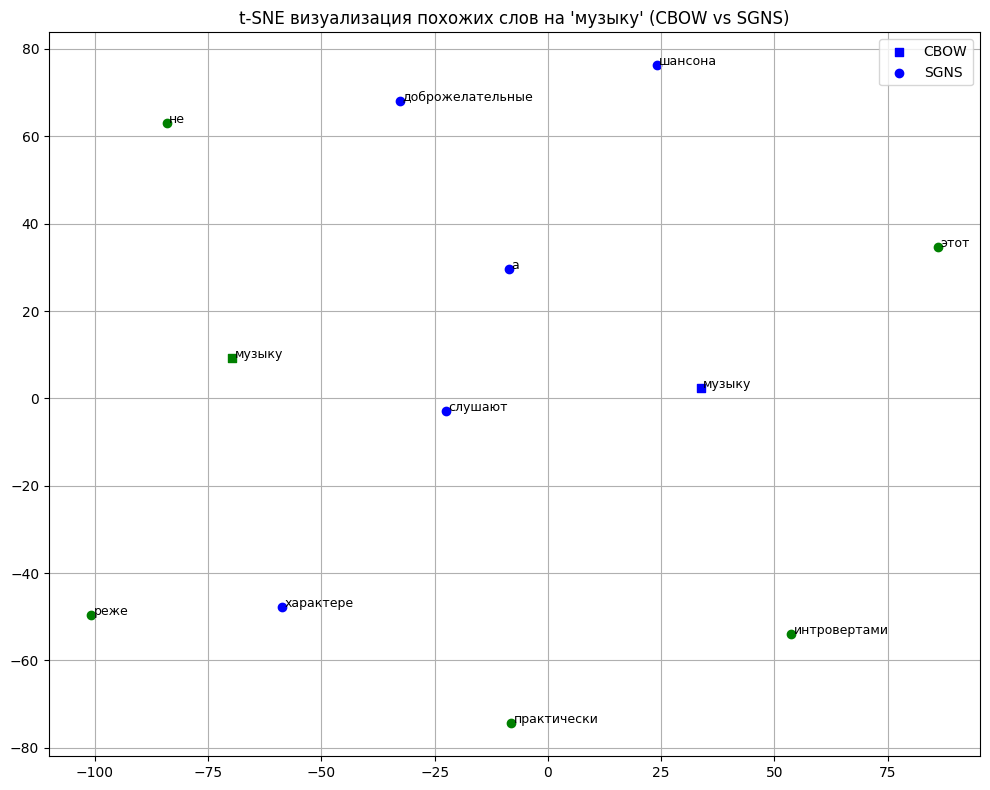

In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

cbow_similar = [('слушают', torch.tensor(0.7630)),
                ('а', torch.tensor(0.6904)),
                ('шансона', torch.tensor(0.6727)),
                ('доброжелательные', torch.tensor(0.6393)),
                ('характере', torch.tensor(0.6337))]

sgns_similar = [('интровертами', torch.tensor(0.8541)),
                ('реже', torch.tensor(0.8330)),
                ('не', torch.tensor(0.8171)),
                ('этот', torch.tensor(0.7848)),
                ('практически', torch.tensor(0.7833))]

query_word = "музыку"
torch.manual_seed(42)
token2vec_cbow = {w: torch.randn(100) for w in [query_word] + [w for w, _ in cbow_similar]}
token2vec_sgns = {w: torch.randn(100) for w in [query_word] + [w for w, _ in sgns_similar]}

cbow_words = [query_word] + [w for w, _ in cbow_similar]
cbow_vectors = [token2vec_cbow[w] for w in cbow_words]

sgns_words = [query_word] + [w for w, _ in sgns_similar]
sgns_vectors = [token2vec_sgns[w] for w in sgns_words]

all_words = ["cbow_" + w for w in cbow_words] + ["sgns_" + w for w in sgns_words]
all_vectors = torch.stack(cbow_vectors + sgns_vectors).numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_result = tsne.fit_transform(all_vectors)


plt.figure(figsize=(10, 8))
for i, word in enumerate(all_words):
    x, y = tsne_result[i]
    color = "blue" if word.startswith("cbow_") else "green"
    marker = "s" if "музыку" in word else "o"
    plt.scatter(x, y, c=color, marker=marker)
    plt.text(x + 0.5, y, word.replace("cbow_", "").replace("sgns_", ""), fontsize=9)

plt.title("t-SNE визуализация похожих слов на 'музыку' (CBOW vs SGNS)")
plt.legend(["CBOW", "SGNS"], loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
## try different embedding sizes and windows and make conclusions

In [35]:
import torch
import plotly.graph_objects as go
from tqdm import tqdm

def run_experiment(embedding_size, window_size):
    eps = 0.1
    vocab_size = len(id2token)

    # CBOW
    cbow_model = CBOW(vocab_size, embedding_size)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=cbow_model.parameters(), lr=eps)

    cbow_error = []
    for epoch in tqdm(range(100)):
        pred = cbow_model(x)
        train_loss = loss_fn(pred, y)
        cbow_error.append(train_loss.item())

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    # SGNS
    sgns_model = SGNS(vocab_size, embedding_size)
    optimizer = torch.optim.Adam(params=sgns_model.parameters(), lr=eps)

    sgns_error = []
    for epoch in tqdm(range(100)):
        loss = sgns_model(x, y, y_neg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sgns_error.append(loss.item())

    # Plotы
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=cbow_error, mode='lines', name=f'CBOW {embedding_size}D, Window {window_size}'))
    fig.add_trace(go.Scatter(y=sgns_error, mode='lines', name=f'SGNS {embedding_size}D, Window {window_size}'))
    fig.update_layout(title=f'Loss Curves for CBOW and SGNS ({embedding_size}D, Window {window_size})',
                      xaxis_title='Epoch',
                      yaxis_title='Loss')
    fig.show()

embedding_sizes = [10, 50, 100]
window_sizes = [1, 3, 5]

for emb_size in embedding_sizes:
    for win_size in window_sizes:
        run_experiment(emb_size, win_size)

100%|██████████| 100/100 [00:00<00:00, 213.81it/s]


100%|██████████| 100/100 [00:00<00:00, 137.44it/s]


100%|██████████| 100/100 [00:00<00:00, 113.12it/s]


100%|██████████| 100/100 [00:01<00:00, 61.76it/s]


100%|██████████| 100/100 [00:01<00:00, 70.65it/s]


100%|██████████| 100/100 [00:01<00:00, 71.01it/s]


100%|██████████| 100/100 [00:02<00:00, 48.35it/s]


100%|██████████| 100/100 [00:02<00:00, 37.76it/s]


100%|██████████| 100/100 [00:01<00:00, 50.04it/s]
